In [130]:
import numpy as np
import scipy.stats as stats
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import theano.tensor as tt

In [118]:
def selection_prob(e_true, th=1.5):
    e_true = np.atleast_1d(e_true)
    res = np.empty_like(e_true)
    
    loge = np.log10(e_true)
    res[loge >= th] = 1
    res[loge < th] = (loge[loge < th]/th)**3
    return res

[]

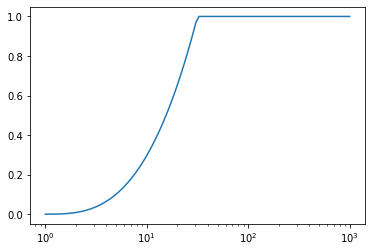

In [132]:
xs = np.logspace(0, 3, 100)
th = 1.5
plt.plot(xs, selection_prob(xs, th))
plt.semilogx()

1.9883177247876265


[]

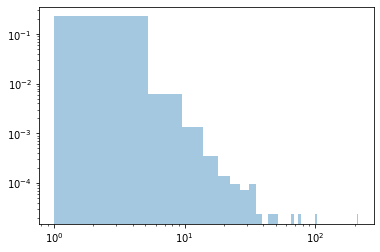

In [133]:
alpha = 2
reco_sigma = 0.2

#e_true = stats.lognorm(scale=mu, s=sigma).rvs(10000)
e_true = stats.pareto(alpha).rvs(10000)
print(np.average(e_true))
sns.distplot(e_true, kde=False, norm_hist=True)
plt.loglog()

[]

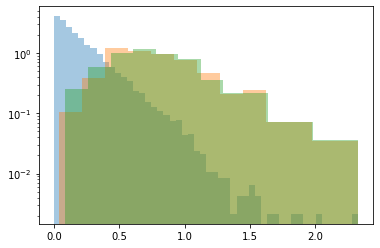

In [134]:
sprob = selection_prob(e_true, th)
#sprob = np.ones_like(e_true)
sel_uni = np.random.uniform(size=e_true.shape)
e_true_det = e_true[sel_uni<=sprob]
sns.distplot(np.log10(e_true), kde=False, norm_hist=True)
sns.distplot(np.log10(e_true_det), kde=False, norm_hist=True)
e_reco_sim = stats.norm.rvs(loc=e_true_det, scale=reco_sigma, size=e_true_det.shape)
sns.distplot(np.log10(e_reco_sim), kde=False, norm_hist=True)
plt.semilogy()

In [142]:
with pm.Model() as model:
    alpha = pm.Gamma("alpha", mu=2, sd=1)
    prior = pm.Pareto("e_true", alpha=alpha, m=1)
    
    e_reco = pm.Normal("e_reco", mu=prior, sd=reco_sigma, observed=e_reco_sim)
    logprior = tt.log10(prior)
    #pot = pm.Potential("pot", tt.switch(tt.lt(logprior, th), (logprior/th)**3, 1))
    pot = pm.Potential("pot", tt.switch(tt.lt(logprior, th), 1-(logprior/th)**3, 0))
    trace = pm.sample(tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [e_true, alpha]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:29<00:00, 343.20draws/s]


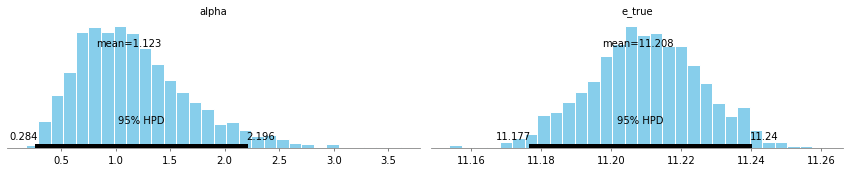

In [143]:
ax = pm.plot_posterior(trace)

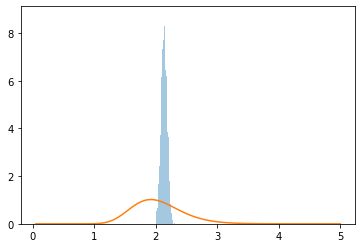

In [77]:
sns.distplot(trace["e_true"], kde=False, norm_hist=True)
#plt.plot(xs, np.exp(model.e_true.distribution.logp(xs).eval()))
plt.plot(xs, np.exp(pm.Lognormal.dist(mu=np.log(mu), sd=sigma).logp(xs).eval()))
#pm.traceplot(trace, priors=[, None])

In [14]:
stats.ks_2samp(trace["e_true"], e_true)

Ks_2sampResult(statistic=0.015900000000000025, pvalue=0.790360775257511)